# Eurovision 2022 (Draft Notebook)


## Potential Research Questions

1. Are Jury Voters less affected by Cultural Influences in Eurovision ?
2. [Needs to be Formulated Well] Does a sympathy-wave effect for Ukraine exist in 2022 Eurovision results?  How can we account for that?


## Plan

### 1. Pre-Analysis or Exploratory Data Analysis

Worth doing again, with newer data.

1. Basically, redo figure 7 from the paper with the newest data

## 2. Agent-Based Models

1. Null Model
2. Model 1
3. Cultural Affinity Model
   a. Cultural Affinity Model part 2


## 3. Find Best Fit

1. Kolmogorov-Smirnov test
2. Hypothesis: Simulated and Empirical FoF come from the same distribution.
    3. This was rejected in the original paper
    
    
### Further Work
1. Consider doing section 5
2. Ambitious: Section 6


Suggestion: Focus on the ABMs as opposed to fully recreating the full paper (K-S tests etc.) 
Also try various things:  subsets of networks.  what happens if you take away a node etc etc.  Give extra weight to Ukraine itself?

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Model, Agent
from mesa.time import RandomActivation
import pyvis.network as pyvisnetwork
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector


from scipy.stats import rankdata
from scipy.stats import ks_2samp

# 1. Exploratory Data Analysis

First, we load the data for the various years and then visualize the network for a given year

In [2]:
#df = pd.read_excel('https://query.data.world/s/cuokq5sbbqlogvjrdwdeacvp367xnq')
df = pd.read_csv("data/dataworld.csv")
df

,Unnamed: 0.1,Unnamed: 0,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


In [3]:
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={
    "(semi-) final": "semi_or_final",
    "Jury or Televoting": "jury_or_televoting",
    "From country": "from",
    "To country": "to",
    "Points": "points"
}, inplace=True)

In [4]:
df_finals = df[df["semi_or_final"] == 'f']
df_finals_televoting = df_finals[df_finals["jury_or_televoting"] == "T"]
df_finals_jury = df_finals[df_finals["jury_or_televoting"] == "J"]

display(df_finals_televoting)
display(df_finals_jury)

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
36352,36352,36352,2016,f,2016f,T,Albania,Armenia,2,NaN
36353,36353,36353,2016,f,2016f,T,Albania,Australia,12,NaN
36354,36354,36354,2016,f,2016f,T,Albania,Austria,0,NaN
36355,36355,36355,2016,f,2016f,T,Albania,Azerbaijan,0,NaN
36356,36356,36356,2016,f,2016f,T,Albania,Belgium,0,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56283,56283,56283,2022,f,2022f,J,United Kingdom,Serbia,1,NaN
56284,56284,56284,2022,f,2022f,J,United Kingdom,Spain,10,NaN
56285,56285,56285,2022,f,2022f,J,United Kingdom,Sweden,12,NaN
56286,56286,56286,2022,f,2022f,J,United Kingdom,Switzerland,2,NaN


Let's visualize!

# Network of votes

In [30]:
df_finals_televoting_2016 = df_finals_televoting[df_finals_televoting["Year"]==2016].copy()
df_finals_televoting_2022 = df_finals_televoting[df_finals_televoting["Year"]==2022].copy()

display(df_finals_televoting_2016)
display(df_finals_televoting_2022)

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
36352,36352,36352,2016,f,2016f,T,Albania,Armenia,2,NaN
36353,36353,36353,2016,f,2016f,T,Albania,Australia,12,NaN
36354,36354,36354,2016,f,2016f,T,Albania,Austria,0,NaN
36355,36355,36355,2016,f,2016f,T,Albania,Azerbaijan,0,NaN
36356,36356,36356,2016,f,2016f,T,Albania,Belgium,0,NaN
...,...,...,...,...,...,...,...,...,...,...
37413,37413,37413,2016,f,2016f,T,United Kingdom,Serbia,0,NaN
37414,37414,37414,2016,f,2016f,T,United Kingdom,Spain,4,NaN
37415,37415,37415,2016,f,2016f,T,United Kingdom,Sweden,1,NaN
37416,37416,37416,2016,f,2016f,T,United Kingdom,The Netherlands,0,NaN


,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
54387,54387,54387,2022,f,2022f,T,Albania,Armenia,0,NaN
54388,54388,54388,2022,f,2022f,T,Albania,Australia,0,NaN
54389,54389,54389,2022,f,2022f,T,Albania,Azerbaijan,0,NaN
54390,54390,54390,2022,f,2022f,T,Albania,Belgium,0,NaN
54391,54391,54391,2022,f,2022f,T,Albania,Czech Republic,0,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


#### A Sample of the Null Model

In [6]:
#df_finals_televoting_2022["null_model_points"] = 0
#
#voting_countries = df_finals_televoting_2022["from"].unique()
#print(f"{voting_countries=}")
#
#for voting_country in voting_countries:
#    country_row_selector = df_finals_televoting_2022["from"] == voting_country
#
#    fit = np.random.uniform(0, 1, size=len(df_finals_televoting_2022[country_row_selector]))
#    #print(f"{voting_country=}, {fit=}")
#
#    points_given = 58 * (fit/sum(fit))
#    #print(f"{voting_country=}, {points_given=}")
#    df_finals_televoting_2022.loc[country_row_selector, "null_model_points"] += points_given
#
#    
#display( df_finals_televoting_2022[ df_finals_televoting_2022["from"] == "Albania" ] )

#### A sample Model1

In [7]:
# TODO: Rules have changed in 2022?

#SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])
#
#df_finals_televoting_2022["model1_points"] = 0
#
#voting_countries = df_finals_televoting_2022["from"].unique()
#
#for voting_country in voting_countries:
#    country_row_selector = df_finals_televoting_2022["from"] == voting_country
#
#    fit = pd.Series( np.random.uniform(0, 1, size=len(df_finals_televoting_2022[country_row_selector])) )
#    rank = fit.rank(ascending=False)
#    points_given = rank.apply(
#        lambda x: SCORES[int(x) - 1] if x <= 10 else 0
#    )
#    print(f"{rank=}, {voting_country=}, {type(points_given)=}")
#    df_finals_televoting_2022.loc[country_row_selector, "model1_points"] += points_given.to_numpy()
#
#
#df_finals_televoting_2022

#### Sample Affinity Model

In [8]:

df_finals_televoting_2022["relative_score"] = df_finals_televoting_2022["points"]/sum(df_finals_televoting_2022["points"])

In [9]:
cultural_network = nx.from_pandas_edgelist(
    df_finals_televoting_2022,
    source="from",
    target="to",
    create_using=nx.DiGraph()
)



mu = 1
sigma = 0.075

dict_weight = {}
for edge in cultural_network.edges():
    sampled_weight = np.random.normal(mu, sigma)
    dict_weight[edge] = sampled_weight

#print(f"{dict_weight=}")

nx.set_edge_attributes(cultural_network, values = dict_weight, name = 'weight')

#for edge in cultural_network.edges():
#    print(f"{edge=}")
nx.get_edge_attributes(cultural_network, "weight")[('Albania', 'Armenia')]

1.0662101707699971

In [10]:
# TODO: Rules have changed in 2022?

#SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])
#alpha = 0.1
#
#
#df_finals_televoting_2022_AT = df_finals_televoting_2022[df_finals_televoting_2022["from"] == "Austria"].copy()
#
#
#def affinity_fit(row):
#    '''
#        row: a dataframe row
#    '''
#    q = float(df_finals_televoting_2022["relative_score"].sample(1))
#    
#    from_country = row['from']
#    to_country = row['to']
#    
#    
#    network_part = nx.get_edge_attributes(cultural_network, "weight")[(from_country, to_country)]
#    
#    the_fit = alpha * q + network_part * (1 - alpha)
#    
#    print(f"{q=}, {from_country=}, {to_country=}, {the_fit=}")
#    return the_fit
#
#
#df_finals_televoting_2022_AT["p_vc"] = df_finals_televoting_2022_AT.apply(lambda row: affinity_fit(row), axis=1)
#
#df_finals_televoting_2022_AT

In [11]:
#weighted_edges = df_finals_televoting_2022.loc[:, ["From country","To country", "Points"]].to_records(index=False)
#voting_graph.add_weighted_edges_from(list(weighted_edges))
voting_graph = nx.from_pandas_edgelist(
    df_finals_televoting_2022,
    source="from",
    target="to",
    edge_attr=["points"],
    create_using=nx.DiGraph()
)

df_finals_televoting_2022

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,relative_score
54387,54387,54387,2022,f,2022f,T,Albania,Armenia,0,NaN,0.000000
54388,54388,54388,2022,f,2022f,T,Albania,Australia,0,NaN,0.000000
54389,54389,54389,2022,f,2022f,T,Albania,Azerbaijan,0,NaN,0.000000
54390,54390,54390,2022,f,2022f,T,Albania,Belgium,0,NaN,0.000000
54391,54391,54391,2022,f,2022f,T,Albania,Czech Republic,0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN,0.000442
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN,0.002210
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN,0.001768
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN,0.000000


In [12]:
display(voting_graph.get_edge_data("United Kingdom", "Ukraine"))
display(voting_graph.get_edge_data("Ukraine", "United Kingdom"))

{'points': 12}

{'points': 7}

In [13]:
voting_graph.number_of_nodes()

40

In [14]:
voting_graph.number_of_edges()

975

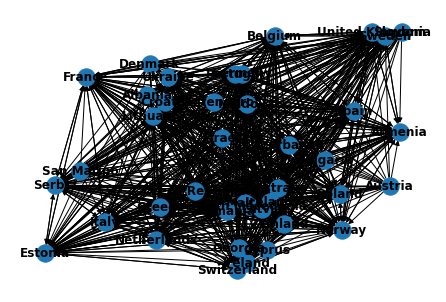

In [15]:
nx.draw_random(voting_graph, with_labels=True, font_weight='bold')

# Agent Based Modelling

## Null Model

In this null model, countries freely vote for other countries.  The only restriction is that they can assign only a fixed amount of points

In [36]:
class NullVotingAgent(Agent):
    
    def __init__(self, unique_id, model, df):
        '''
         Create a new Null Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        self.unique_id
        
        country_row_selector = df["from"] == unique_id

        fit = np.random.uniform(0, 1, size=len(df[country_row_selector]))

        points_given = 58 * (fit/sum(fit))
        
        #print(f"{voting_country=}, {points_given=}")
        df.loc[country_row_selector, "null_model_points"] += points_given
        
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        pass


In [43]:
def get_model1_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["null_model_FoF"]
    
    return ks_2samp(data1, data2)

class NullVotingModel(Model):
    
    def __init__(self, df):
        '''
        Create a new NullVotingModel model.

         Args:
            df: A dataframe of votes, containing, at least, 
                * from
                * to
                * points
        '''
        
        super().__init__()

        self.df = df
        
        self.datacollector = DataCollector(
            model_reporters={"ks": get_model1_ks}
        )
        
        self.schedule = RandomActivation(self)
        
        
        self.df["null_model_points"] = 0
        self.df["FoF"] = 0
        self.df["null_model_FoF"] = 0

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            the_agent = NullVotingAgent(voting_country, self, self.df)
            self.schedule.add(the_agent)
            

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        
        self.datacollector.collect(self)
        self.schedule.step()

In [18]:
the_model = NullVotingModel(df_finals_televoting_2022)

df_finals_televoting_2022[df_finals_televoting_2022["from"] == "Australia"]

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,relative_score,null_model_points
54484,54484,54484,2022,f,2022f,T,Australia,Armenia,0,NaN,0.000000,0.884158
54485,54485,54485,2022,f,2022f,T,Australia,Azerbaijan,0,NaN,0.000000,2.426903
54486,54486,54486,2022,f,2022f,T,Australia,Belgium,0,NaN,0.000000,0.004475
54487,54487,54487,2022,f,2022f,T,Australia,Czech Republic,0,NaN,0.000000,0.811032
54488,54488,54488,2022,f,2022f,T,Australia,Estonia,0,NaN,0.000000,3.423369
54489,54489,54489,2022,f,2022f,T,Australia,Finland,0,NaN,0.000000,4.269117
54490,54490,54490,2022,f,2022f,T,Australia,France,0,NaN,0.000000,1.798391
54491,54491,54491,2022,f,2022f,T,Australia,Germany,0,NaN,0.000000,3.335700
54492,54492,54492,2022,f,2022f,T,Australia,Greece,0,NaN,0.000000,4.162646
54493,54493,54493,2022,f,2022f,T,Australia,Iceland,0,NaN,0.000000,4.371825


## Model1 ABM

In [19]:
class Model1Agent(Agent):
    
    def __init__(self, unique_id, model, df):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        
        country_row_selector = df["from"] == unique_id

        fit = pd.Series( np.random.uniform(0, 1, size=len(df[country_row_selector])) )
        rank = fit.rank(ascending=False)
        points_given = rank.apply(
            lambda x: SCORES[int(x) - 1] if x <= 10 else 0
        )
        
        #print(f"{rank=}, {voting_country=}, {type(points_given)=}")
        df.loc[country_row_selector, "model1_points"] += points_given.to_numpy()
        
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        pass


In [20]:
def get_model1_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["model1_FoF"]
    
    return ks_2samp(data1, data2)


class Model1Model(Model):
    
    def __init__(self, df):
        '''
        Create a new NullVotingModel model.

         Args:
            df: A dataframe of votes, containing, at least, 
                * from
                * to
                * points
        '''
        
        super().__init__()

        self.df = df
        
        self.datacollector = DataCollector(
            model_reporters={"ks": get_model1_ks}
        )
        
        self.df["model1_points"] = 0

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            a = Model1Agent(voting_country, self, self.df)
            

    def step(self):
        '''
        Run one step of the model.
        '''
        
        pass

In [21]:
SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])
the_model = Model1Model(df_finals_televoting_2022)

df_finals_televoting_2022[df_finals_televoting_2022["from"] == "Australia"]

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,relative_score,null_model_points,model1_points
54484,54484,54484,2022,f,2022f,T,Australia,Armenia,0,NaN,0.000000,0.884158,0
54485,54485,54485,2022,f,2022f,T,Australia,Azerbaijan,0,NaN,0.000000,2.426903,0
54486,54486,54486,2022,f,2022f,T,Australia,Belgium,0,NaN,0.000000,0.004475,0
54487,54487,54487,2022,f,2022f,T,Australia,Czech Republic,0,NaN,0.000000,0.811032,1
54488,54488,54488,2022,f,2022f,T,Australia,Estonia,0,NaN,0.000000,3.423369,12
54489,54489,54489,2022,f,2022f,T,Australia,Finland,0,NaN,0.000000,4.269117,0
54490,54490,54490,2022,f,2022f,T,Australia,France,0,NaN,0.000000,1.798391,0
54491,54491,54491,2022,f,2022f,T,Australia,Germany,0,NaN,0.000000,3.335700,7
54492,54492,54492,2022,f,2022f,T,Australia,Greece,0,NaN,0.000000,4.162646,3
54493,54493,54493,2022,f,2022f,T,Australia,Iceland,0,NaN,0.000000,4.371825,8


## Affinity Model

In [22]:
class AffinityModelAgent(Agent):
    
    def __init__(self, unique_id, model, df, cultural_network):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        
        country_row_selector = df["from"] == unique_id
        
        def affinity_fit(row):
            '''
                row: a dataframe row
            '''
            q = float(df["relative_score"].sample(1))

            from_country = row['from']
            to_country = row['to']


            network_part = nx.get_edge_attributes(cultural_network, "weight")[(from_country, to_country)]

            the_fit = alpha * q + network_part * (1 - alpha)

            return the_fit

        
        country_df = df[country_row_selector]

        fit = country_df.apply(
            lambda row: affinity_fit(row), axis=1
        )
        #print(f"{unique_id=}, {fit=}")
        rank = fit.rank(ascending=False)
        points_given = rank.apply(
            lambda x: SCORES[int(x) - 1] if x <= 10 else 0
        )
        
        df.loc[country_row_selector, "affinity_model_points"] += points_given.to_numpy()
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        pass


In [23]:
def get_affinity_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["affinity_model_FoF"]
    
    return ks_2samp(data1, data2)


class AffinityModel(Model):
    
    def __init__(self, df, cultural_network):
        '''
        Create a new NullVotingModel model.

         Args:
            df: A dataframe of votes, containing, at least, 
                * from
                * to
                * points
        '''
        
        super().__init__()
        
        self.datacollector = DataCollector(
            model_reporters={"ks": get_affinity_ks}
        )

        self.df = df
        self.df["affinity_model_points"] = 0
        
        self.cultural_network = cultural_network

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            a = AffinityModelAgent(voting_country, self, self.df, self.cultural_network)
            

    def step(self):
        '''
        Run one step of the model.
        '''
        
        pass

In [24]:
SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])
alpha = 0.1
the_model = AffinityModel(df_finals_televoting_2022, cultural_network)

df_finals_televoting_2022[df_finals_televoting_2022["from"] == "United Kingdom"]

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,relative_score,null_model_points,model1_points,affinity_model_points
56288,56288,56288,2022,f,2022f,T,United Kingdom,Armenia,0,NaN,0.000000,4.444522,0,0
56289,56289,56289,2022,f,2022f,T,United Kingdom,Australia,0,NaN,0.000000,0.506105,0,12
56290,56290,56290,2022,f,2022f,T,United Kingdom,Azerbaijan,0,NaN,0.000000,2.670335,0,0
56291,56291,56291,2022,f,2022f,T,United Kingdom,Belgium,0,NaN,0.000000,0.630830,0,2
56292,56292,56292,2022,f,2022f,T,United Kingdom,Czech Republic,0,NaN,0.000000,1.091087,0,0
56293,56293,56293,2022,f,2022f,T,United Kingdom,Estonia,2,NaN,0.000884,0.404300,0,1
56294,56294,56294,2022,f,2022f,T,United Kingdom,Finland,0,NaN,0.000000,4.123436,0,0
56295,56295,56295,2022,f,2022f,T,United Kingdom,France,0,NaN,0.000000,4.581260,0,0
56296,56296,56296,2022,f,2022f,T,United Kingdom,Germany,0,NaN,0.000000,3.222529,7,7
56297,56297,56297,2022,f,2022f,T,United Kingdom,Greece,0,NaN,0.000000,2.295624,5,0


# 3. Run the ABMs in a batch for various years



# 4. Friend-Or-Foe for the ABMS

Now that we have Various models and also empirical data, we can calculate the Friend-or-Foe coefficients for each of them

In [25]:
def get_FoF(df, from_country, to_country, points_column = "points"):
    Voter_selector = df["from"] == from_country
    Candidate_selector = df["to"] == to_country

    voting_countries_2022 = df["from"].unique()


    N = len(voting_countries_2022)

    final_score = sum(df.loc[Candidate_selector, points_column])

    points = df.loc[Voter_selector & Candidate_selector, points_column]

    FoF =  ( points / 12 ) - ( ( final_score - points )/( 12*(N-2) ) )
    
    return FoF


print(f"{get_FoF(df_finals_televoting_2022, 'United Kingdom', 'Australia', 'null_model_points')}")

56289   -0.167763
Name: null_model_points, dtype: float64


In [26]:
def calc_All_FoF(df, from_country, points_column = "points", FoF_column = "FoF"):
    Voter_selector = df["from"] == from_country

    voting_countries_2022 = df["from"].unique()


    N = len(voting_countries_2022)
    
    for to_country in df["to"].unique():
        Candidate_selector = df["to"] == to_country

        final_score = sum(df.loc[Candidate_selector, points_column])

        points = df.loc[Voter_selector & Candidate_selector, points_column]

        df.loc[Voter_selector & Candidate_selector, FoF_column ] =  ( points / 12 ) - ( ( final_score - points )/( 12*(N-2) ) )

        
        
for voting_country in df["from"].unique():
    calc_All_FoF(df_finals_televoting_2022, voting_country, 'points', "FoF")        
    calc_All_FoF(df_finals_televoting_2022, voting_country, 'null_model_points', "null_model_FoF")
    calc_All_FoF(df_finals_televoting_2022, voting_country, 'model1_points', "model1_FoF")
    calc_All_FoF(df_finals_televoting_2022, voting_country, 'affinity_model_points', "affinity_model_FoF")

In [27]:
df_finals_televoting_2022[df_finals_televoting_2022["from"] == "Australia"]

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,relative_score,null_model_points,model1_points,affinity_model_points,FoF,null_model_FoF,model1_FoF,affinity_model_FoF
54484,54484,54484,2022,f,2022f,T,Australia,Armenia,0,NaN,0.000000,0.884158,0,5,-0.046053,-0.099869,-0.175439,0.212719
54485,54485,54485,2022,f,2022f,T,Australia,Azerbaijan,0,NaN,0.000000,2.426903,0,1,-0.006579,-0.011315,-0.125000,-0.041667
54486,54486,54486,2022,f,2022f,T,Australia,Belgium,0,NaN,0.000000,0.004475,0,0,-0.010965,-0.228825,-0.245614,-0.179825
54487,54487,54487,2022,f,2022f,T,Australia,Czech Republic,0,NaN,0.000000,0.811032,1,0,-0.010965,-0.108677,-0.065789,-0.186404
54488,54488,54488,2022,f,2022f,T,Australia,Estonia,0,NaN,0.000000,3.423369,12,4,-0.201754,0.115632,0.833333,0.146930
54489,54489,54489,2022,f,2022f,T,Australia,Finland,0,NaN,0.000000,4.269117,0,3,-0.057018,0.156899,-0.175439,0.070175
54490,54490,54490,2022,f,2022f,T,Australia,France,0,NaN,0.000000,1.798391,0,0,-0.013158,-0.064412,-0.265351,-0.195175
54491,54491,54491,2022,f,2022f,T,Australia,Germany,0,NaN,0.000000,3.335700,7,0,-0.013158,0.057650,0.364035,-0.164474
54492,54492,54492,2022,f,2022f,T,Australia,Greece,0,NaN,0.000000,4.162646,3,12,-0.125000,0.140157,0.103070,0.695175
54493,54493,54493,2022,f,2022f,T,Australia,Iceland,0,NaN,0.000000,4.371825,8,0,-0.021930,0.172278,0.484649,-0.219298


In [28]:
data1 = df_finals_televoting_2022["FoF"]
data2 = df_finals_televoting_2022["affinity_model_FoF"]

ks_2samp(data1, data2)

KstestResult(statistic=0.4194871794871795, pvalue=2.9894708966091785e-77)

In [29]:
#the_model.step()

the_model.datacollector.collect(the_model)


the_model.datacollector.get_model_vars_dataframe()

,ks
0,"(0.4194871794871795, 2.9894708966091785e-77)"


## Batch Run

In [47]:
params_null = {
    "jury_or_televoting": "T",
    "years": [2021, 2022]    # 2020 Contest was cancelled due to COVID-19
} 


params_model1 = {
    "jury_or_televoting": "T",
    "years": [2022]    # 2020 Contest was cancelled due to COVID-19
} 

params_affinity = {
    "jury_or_televoting": "T",
    "years": [2022]    # 2020 Contest was cancelled due to COVID-19
    "mu": np.linspace(-0.1, 0.1, 0.01),
    "sigma": np.linspace(1, 0.1, 0.005)
} 

In [48]:
from mesa.batchrunner import batch_run

results = batch_run(
    NullVotingModel,
    parameters=params_null,
    iterations=10,
    max_steps=1,
    number_processes=None,
    data_collection_period=-1,
    display_progress=True,
)

0it [00:00, ?it/s]


TypeError: unhashable type: 'DataFrame'